# MIS382N: Final Project – Kickstarter Success Prediction

Nathan Spencer, Minuk Choi, Alefia Aziz Ali

---

## Overview

This notebook analyzes **27,251 Kickstarter campaigns** to predict funding success using three data modalities:

1. **Tabular metadata** (goal, category, country, duration)
2. **Text descriptions** (campaign blurbs)
3. **Images** (campaign thumbnails)

We compare Logistic Regression, Random Forest, XGBoost, TF-IDF, Neural Networks, and ResNet18 transfer learning.

**Key finding:** An ensemble of Logistic Regression + XGBoost on combined tabular + text features achieves **0.871 AUC**.

---
# 1. Data Loading

We assume the Kaggle datasets are already downloaded to `./data/`.

**Data sources (Kaggle, by Alonso Puente):**
- `kickstarter-projects-metadata`
- `kickstarter-projects-descriptions`
- `kickstarter-projects-images`

To download: set up your Kaggle API credentials per https://www.kaggle.com/docs/api, then run:
```bash
kaggle datasets download alonsopuente/kickstarter-projects-metadata -p ./data --unzip
kaggle datasets download alonsopuente/kickstarter-projects-descriptions -p ./data --unzip
kaggle datasets download alonsopuente/kickstarter-projects-images -p ./data --unzip
```

In [4]:
# ============================================================
# OPTIONAL: Simple Kaggle download helper
# ============================================================

import os, json, stat

#    Get them from kaggle.com -> Account -> API -> Create New Token
KAGGLE_USERNAME = "your_kaggle_username"
KAGGLE_KEY      = "your_api_key_here"

# If user didn't change the placeholders, skip to avoid confusing errors
if KAGGLE_USERNAME == "your_kaggle_username" or KAGGLE_KEY == "your_api_key_here":
    print("Kaggle credentials not set. "
          "Either edit KAGGLE_USERNAME / KAGGLE_KEY locally or skip this cell.")
else:
    # 2) Write kaggle.json
    kaggle_dir = os.path.expanduser("~/.kaggle")
    os.makedirs(kaggle_dir, exist_ok=True)

    kaggle_creds = {"username": KAGGLE_USERNAME, "key": KAGGLE_KEY}
    cred_path = os.path.join(kaggle_dir, "kaggle.json")

    with open(cred_path, "w") as f:
        json.dump(kaggle_creds, f)

    os.chmod(cred_path, stat.S_IRUSR | stat.S_IWUSR)
    print("✅ Saved kaggle.json to", cred_path)

    # 3) Install Kaggle CLI if needed
    %pip install -q kaggle

    # 4) Make data folder and download datasets (~2GB total, mostly images)
    os.makedirs("data", exist_ok=True)

    print("⬇️  Downloading metadata...")
    !kaggle datasets download alonsopuente/kickstarter-projects-metadata     -p ./data --unzip

    print("⬇️  Downloading descriptions...")
    !kaggle datasets download alonsopuente/kickstarter-projects-descriptions -p ./data --unzip

    print("⬇️  Downloading images (≈2GB)...")
    !kaggle datasets download alonsopuente/kickstarter-projects-images       -p ./data --unzip

    print("\n✅ Done. Contents of ./data:")
    !ls -la ./data

✅ Saved kaggle.json to /root/.kaggle/kaggle.json
⬇️  Downloading metadata...
Dataset URL: https://www.kaggle.com/datasets/alonsopuente/kickstarter-projects-metadata
License(s): unknown
  0% 0.00/5.78M [00:00<?, ?B/s]
100% 5.78M/5.78M [00:00<00:00, 1.19GB/s]
⬇️  Downloading descriptions...
Dataset URL: https://www.kaggle.com/datasets/alonsopuente/kickstarter-projects-descriptions
License(s): unknown
  0% 0.00/35.1M [00:00<?, ?B/s]
100% 35.1M/35.1M [00:00<00:00, 1.72GB/s]
⬇️  Downloading images (≈2GB)...
Dataset URL: https://www.kaggle.com/datasets/alonsopuente/kickstarter-projects-images
License(s): unknown
 98% 2.20G/2.24G [00:19<00:00, 44.4MB/s]
100% 2.24G/2.24G [00:19<00:00, 121MB/s] 
total 111312
drwxr-xr-x 3 root root     4096 Dec 10 22:21  .
drwxr-xr-x 1 root root     4096 Dec 10 22:08  ..
-rw-r--r-- 1 root root 95437368 Dec 10 22:18 'data completa descripciones.csv'
drwxr-xr-x 2 root root   958464 Dec 10 22:21  images
-rw-r--r-- 1 root root   367308 Dec 10 22:21  labeled_projects

In [5]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Verify data exists
meta_path = "./data/Metadata.csv"
assert os.path.exists(meta_path), f"Expected {meta_path}. Please download the Kaggle datasets first."

meta = pd.read_csv(meta_path)
print(f"Loaded metadata: {meta.shape[0]:,} projects, {meta.shape[1]} columns")

# Quick look at funding outcomes
value_col = "usd_pledged" if "usd_pledged" in meta.columns else "pledged"
valid = meta[meta[value_col].notna() & (meta[value_col] >= 0)]

success_mask = valid["state"] == "successful"
failed_mask = valid["state"] == "failed"

print(f"\nAverage raised (successful): ${valid.loc[success_mask, value_col].mean():,.2f}")
print(f"Average raised (failed):     ${valid.loc[failed_mask, value_col].mean():,.2f}")

Loaded metadata: 27,251 projects, 19 columns

Average raised (successful): $92,758.08
Average raised (failed):     $2,210.21


---
# 2. Preprocessing & Train/Test Split

**Key preprocessing steps:**
- Binary target: `success = 1` if campaign reached its goal
- Log-transform `goal` (spans 8 orders of magnitude: $1 to $100M)
- Stratified 80/20 split to preserve the ~28% success rate in both sets

In [6]:
from sklearn.model_selection import train_test_split

df = meta.copy()

# Binary target
df["success"] = (df["state"] == "successful").astype(int)

# Log-transform goal
df["log_goal"] = np.log1p(df["goal"])

# Fill missing categories
df["category"] = df["category"].fillna("unknown")

# Stratified split
train_df, test_df = train_test_split(
    df, test_size=0.2, stratify=df["success"], random_state=42
)

print(f"Train: {len(train_df):,} ({train_df['success'].mean():.1%} success)")
print(f"Test:  {len(test_df):,} ({test_df['success'].mean():.1%} success)")

Train: 21,800 (28.4% success)
Test:  5,451 (28.4% success)


---
# 3. Tabular Baselines (LR, Random Forest, XGBoost)

We start with structured metadata: log-transformed goal, duration, country, and category.

These simple features already get us into the low-to-mid 0.8s on AUC.

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, roc_auc_score

numeric_features = ["log_goal", "duration"]
categorical_features = ["country", "category"]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ]
)

X_train = train_df[numeric_features + categorical_features]
y_train = train_df["success"]
X_test = test_df[numeric_features + categorical_features]
y_test = test_df["success"]

# Logistic Regression
lr_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(max_iter=1000, random_state=42))
])
lr_pipeline.fit(X_train, y_train)
lr_probs = lr_pipeline.predict_proba(X_test)[:, 1]
lr_auc = roc_auc_score(y_test, lr_probs)

# Random Forest
rf_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1))
])
rf_pipeline.fit(X_train, y_train)
rf_probs = rf_pipeline.predict_proba(X_test)[:, 1]
rf_auc = roc_auc_score(y_test, rf_probs)

print(f"Logistic Regression AUC: {lr_auc:.3f}")
print(f"Random Forest AUC:       {rf_auc:.3f}")

Logistic Regression AUC: 0.833
Random Forest AUC:       0.811


## 3.1 XGBoost + Feature Importance

XGBoost achieves the best tabular-only AUC (~0.85). Feature importance reveals that **category dominates** (~88% of predictive power).

In [8]:
from xgboost import XGBClassifier

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

xgb = XGBClassifier(
    n_estimators=200, max_depth=6, learning_rate=0.1,
    random_state=42, eval_metric='auc'
)
xgb.fit(X_train_processed, y_train)
xgb_probs = xgb.predict_proba(X_test_processed)[:, 1]
xgb_auc = roc_auc_score(y_test, xgb_probs)

print(f"XGBoost AUC: {xgb_auc:.3f}")

# Feature importance by type
feature_names = (numeric_features +
                 list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)))

importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': xgb.feature_importances_
})

def get_feature_type(name):
    if name in numeric_features:
        return 'Numeric'
    elif name.startswith('country_'):
        return 'Country'
    else:
        return 'Category'

importance_df['type'] = importance_df['feature'].apply(get_feature_type)
type_importance = importance_df.groupby('type')['importance'].sum().sort_values(ascending=False)

print("\nImportance by feature type:")
for feat_type, imp in type_importance.items():
    print(f"  {feat_type}: {imp:.1%}")

XGBoost AUC: 0.849

Importance by feature type:
  Category: 87.7%
  Country: 10.8%
  Numeric: 1.5%


---
# 4. Text Models (TF-IDF + Neural Network)

We analyze campaign blurbs using TF-IDF with up to 5,000 features and bigrams.

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

train_texts = train_df["blurb"].fillna("")
test_texts = test_df["blurb"].fillna("")

tfidf = TfidfVectorizer(max_features=5000, stop_words="english", ngram_range=(1, 2))
X_train_tfidf = tfidf.fit_transform(train_texts)
X_test_tfidf = tfidf.transform(test_texts)

print(f"TF-IDF matrix shape: {X_train_tfidf.shape}")

# Logistic Regression on text
lr_text = LogisticRegression(max_iter=1000, random_state=42)
lr_text.fit(X_train_tfidf, y_train)
text_probs = lr_text.predict_proba(X_test_tfidf)[:, 1]
text_auc = roc_auc_score(y_test, text_probs)

print(f"TF-IDF + Logistic Regression AUC: {text_auc:.3f}")

# Most predictive words
feature_names = tfidf.get_feature_names_out()
coefficients = lr_text.coef_[0]

top_success = np.argsort(coefficients)[-5:]
top_fail = np.argsort(coefficients)[:5]

print("\nTop words predicting SUCCESS:")
for idx in reversed(top_success):
    print(f"  {feature_names[idx]:15s} ({coefficients[idx]:+.2f})")

print("\nTop words predicting FAILURE:")
for idx in top_fail:
    print(f"  {feature_names[idx]:15s} ({coefficients[idx]:+.2f})")

TF-IDF matrix shape: (21800, 5000)
TF-IDF + Logistic Regression AUC: 0.784

Top words predicting SUCCESS:
  clock           (+2.57)
  arduino         (+2.46)
  python          (+2.06)
  conference      (+2.04)
  smart           (+2.04)

Top words predicting FAILURE:
  app             (-4.47)
  website         (-3.21)
  platform        (-2.41)
  site            (-2.24)
  dating          (-2.22)


## 4.1 Neural Network Text Model

We first tried a larger neural model (embed_dim=128, hidden_dim=64) that overfit and never beat TF-IDF.

Below is a smaller, regularized version with dropout and early stopping. It roughly matches TF-IDF but doesn't outperform it, confirming that for short text, sparse bag-of-words features work well.

In [10]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from collections import Counter

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Build vocabulary
def tokenize(text):
    return str(text).lower().split()

word_counts = Counter()
for text in train_df["blurb"].fillna(""):
    word_counts.update(tokenize(text))

vocab_size = 10000
most_common = word_counts.most_common(vocab_size - 2)
word_to_idx = {word: idx + 2 for idx, (word, _) in enumerate(most_common)}
word_to_idx["<PAD>"] = 0
word_to_idx["<UNK>"] = 1

def encode_text(text, max_len=50):
    tokens = tokenize(text)[:max_len]
    indices = [word_to_idx.get(token, 1) for token in tokens]
    return indices + [0] * (max_len - len(indices))

class KickstarterTextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        text = self.texts.iloc[idx] if hasattr(self.texts, 'iloc') else self.texts[idx]
        encoded = encode_text(text if pd.notna(text) else "")
        return (
            torch.tensor(encoded, dtype=torch.long),
            torch.tensor(self.labels.iloc[idx], dtype=torch.float)
        )

train_dataset = KickstarterTextDataset(train_df["blurb"], train_df["success"])
test_dataset = KickstarterTextDataset(test_df["blurb"], test_df["success"])
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print(f"Train batches: {len(train_loader)}, Test batches: {len(test_loader)}")

Using device: cuda
Train batches: 341, Test batches: 86


In [11]:
class TextClassifier(nn.Module):
    """Regularized text classifier with smaller architecture"""
    def __init__(self, vocab_size, embed_dim=100, hidden_dim=32):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.dropout_embed = nn.Dropout(0.5)
        self.fc1 = nn.Linear(embed_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        embedded = self.dropout_embed(self.embedding(x))
        pooled = embedded.mean(dim=1)
        hidden = self.dropout(self.relu(self.fc1(pooled)))
        return self.fc2(hidden).squeeze(-1)

model = TextClassifier(vocab_size=len(word_to_idx))
model = model.to(device)
print(f"Parameters: {sum(p.numel() for p in model.parameters()):,}")

# Training with early stopping
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

best_auc = 0
patience, patience_counter = 3, 0

for epoch in range(20):
    model.train()
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        loss = criterion(model(X_batch), y_batch)
        loss.backward()
        optimizer.step()

    # Evaluate
    model.eval()
    all_probs, all_labels = [], []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            probs = torch.sigmoid(model(X_batch.to(device)))
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(y_batch.numpy())

    test_auc = roc_auc_score(all_labels, all_probs)
    marker = "*" if test_auc > best_auc else ""

    if test_auc > best_auc:
        best_auc = test_auc
        patience_counter = 0
    else:
        patience_counter += 1

    print(f"Epoch {epoch+1:2d} | AUC: {test_auc:.3f} {marker}")

    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

nn_text_auc = best_auc
print(f"\nBest Neural Text AUC: {nn_text_auc:.3f}")
print(f"TF-IDF baseline:      {text_auc:.3f}")

Parameters: 1,003,265
Epoch  1 | AUC: 0.605 *
Epoch  2 | AUC: 0.659 *
Epoch  3 | AUC: 0.701 *
Epoch  4 | AUC: 0.737 *
Epoch  5 | AUC: 0.756 *
Epoch  6 | AUC: 0.765 *
Epoch  7 | AUC: 0.774 *
Epoch  8 | AUC: 0.777 *
Epoch  9 | AUC: 0.779 *
Epoch 10 | AUC: 0.783 *
Epoch 11 | AUC: 0.782 
Epoch 12 | AUC: 0.784 *
Epoch 13 | AUC: 0.784 
Epoch 14 | AUC: 0.784 
Epoch 15 | AUC: 0.783 
Early stopping at epoch 15

Best Neural Text AUC: 0.784
TF-IDF baseline:      0.784


---
# 5. Image Model (ResNet18)

We fine-tune ResNet18 (pretrained on ImageNet) on campaign thumbnails. Only the final classification layer is trained.

In [12]:
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image

image_dir = "./data/images"
if os.path.exists(image_dir):
    available_images = set(os.listdir(image_dir))
    print(f"Total images available: {len(available_images)}")
else:
    print("Image directory not found. Skipping image model.")
    available_images = set()

def get_image_path(project_id):
    filename = f"{project_id}.png"
    if filename in available_images:
        return os.path.join(image_dir, filename)
    return None

train_df["image_path"] = train_df["id"].apply(get_image_path)
test_df["image_path"] = test_df["id"].apply(get_image_path)

train_with_images = train_df[train_df["image_path"].notna()].copy()
test_with_images = test_df[test_df["image_path"].notna()].copy()

print(f"Train with images: {len(train_with_images):,}")
print(f"Test with images:  {len(test_with_images):,}")

Total images available: 27248
Train with images: 21,799
Test with images:  5,449


In [13]:
# Validate images and set up data loaders
def is_valid_image(path):
    try:
        with Image.open(path) as img:
            img.load()
            img.convert("RGB")
        return True
    except:
        return False

if len(available_images) > 0:
    print("Validating images...")
    train_with_images["valid"] = train_with_images["image_path"].apply(is_valid_image)
    test_with_images["valid"] = test_with_images["image_path"].apply(is_valid_image)

    train_valid = train_with_images[train_with_images["valid"]].copy()
    test_valid = test_with_images[test_with_images["valid"]].copy()

    print(f"Valid train images: {len(train_valid):,}")
    print(f"Valid test images:  {len(test_valid):,}")

    image_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    class KickstarterImageDataset(Dataset):
        def __init__(self, df, transform):
            self.paths = df["image_path"].tolist()
            self.labels = df["success"].tolist()
            self.transform = transform

        def __len__(self):
            return len(self.labels)

        def __getitem__(self, idx):
            img = Image.open(self.paths[idx]).convert("RGB")
            return self.transform(img), torch.tensor(self.labels[idx], dtype=torch.float)

    train_img_dataset = KickstarterImageDataset(train_valid, image_transforms)
    test_img_dataset = KickstarterImageDataset(test_valid, image_transforms)
    train_img_loader = DataLoader(train_img_dataset, batch_size=32, shuffle=True)
    test_img_loader = DataLoader(test_img_dataset, batch_size=32, shuffle=False)

Validating images...


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Valid train images: 21,795
Valid test images:  5,448


In [14]:
# Train ResNet18
if len(available_images) > 0:
    resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    for param in resnet.parameters():
        param.requires_grad = False
    resnet.fc = nn.Linear(resnet.fc.in_features, 1)
    resnet = resnet.to(device)

    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(resnet.parameters(), lr=0.001)

    img_history = []
    print("Training ResNet18...")

    for epoch in range(5):
        resnet.train()
        for X_batch, y_batch in train_img_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            loss = criterion(resnet(X_batch).squeeze(-1), y_batch)
            loss.backward()
            optimizer.step()

        resnet.eval()
        all_probs, all_labels = [], []
        with torch.no_grad():
            for X_batch, y_batch in test_img_loader:
                probs = torch.sigmoid(resnet(X_batch.to(device)).squeeze(-1))
                all_probs.extend(probs.cpu().numpy())
                all_labels.extend(y_batch.numpy())

        img_auc = roc_auc_score(all_labels, all_probs)
        img_history.append(img_auc)
        print(f"Epoch {epoch+1}/5 | Test AUC: {img_auc:.3f}")

    resnet_auc = max(img_history)
    print(f"\nBest ResNet18 AUC: {resnet_auc:.3f}")
    print("Note: This is only slightly better than random (0.5), suggesting thumbnails have minimal predictive power.")
else:
    resnet_auc = 0.591  # Placeholder from original results
    print(f"ResNet18 AUC (from original run): {resnet_auc:.3f}")

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 163MB/s]


Training ResNet18...


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/5 | Test AUC: 0.577


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 2/5 | Test AUC: 0.591


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 3/5 | Test AUC: 0.582


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 4/5 | Test AUC: 0.586


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 5/5 | Test AUC: 0.581

Best ResNet18 AUC: 0.591
Note: This is only slightly better than random (0.5), suggesting thumbnails have minimal predictive power.


---
# 6. Fusion & Ensemble Models

We combine tabular metadata with text features. This gives us our best overall performance.

In [15]:
from scipy.sparse import hstack, csr_matrix

# Combine tabular + text features
X_train_tab = preprocessor.fit_transform(X_train)
X_test_tab = preprocessor.transform(X_test)

X_train_combined = hstack([csr_matrix(X_train_tab), X_train_tfidf])
X_test_combined = hstack([csr_matrix(X_test_tab), X_test_tfidf])

print(f"Combined feature shape: {X_train_combined.shape}")

# Logistic Regression on combined
lr_combined = LogisticRegression(max_iter=1000, random_state=42)
lr_combined.fit(X_train_combined, y_train)
combined_probs = lr_combined.predict_proba(X_test_combined)[:, 1]
combined_auc = roc_auc_score(y_test, combined_probs)

# XGBoost on combined
xgb_combined = XGBClassifier(
    n_estimators=200, max_depth=6, learning_rate=0.1,
    random_state=42, eval_metric='auc', n_jobs=-1
)
xgb_combined.fit(X_train_combined, y_train)
xgb_combined_probs = xgb_combined.predict_proba(X_test_combined)[:, 1]
xgb_combined_auc = roc_auc_score(y_test, xgb_combined_probs)

# Ensemble: average of LR and XGBoost
ensemble_probs = (combined_probs + xgb_combined_probs) / 2
ensemble_auc = roc_auc_score(y_test, ensemble_probs)

print(f"\nLR (Tab+Text) AUC:      {combined_auc:.3f}")
print(f"XGBoost (Tab+Text) AUC: {xgb_combined_auc:.3f}")
print(f"Ensemble (LR+XGB) AUC:  {ensemble_auc:.3f}")

Combined feature shape: (21800, 5041)

LR (Tab+Text) AUC:      0.868
XGBoost (Tab+Text) AUC: 0.861
Ensemble (LR+XGB) AUC:  0.871


---
# 7. Final Model Comparison

Final Model Rankings:
---------------------------------------------
1. Ensemble (LR+XGB, Tab+Text)      0.871
2. LR (Tab+Text)                    0.868
3. XGBoost (Tab+Text)               0.861
4. XGBoost (Tabular)                0.849
5. LR (Tabular)                     0.833
6. Random Forest (Tabular)          0.811
7. Neural Network Text              0.784
8. TF-IDF Text                      0.784
9. ResNet18 Image                   0.591


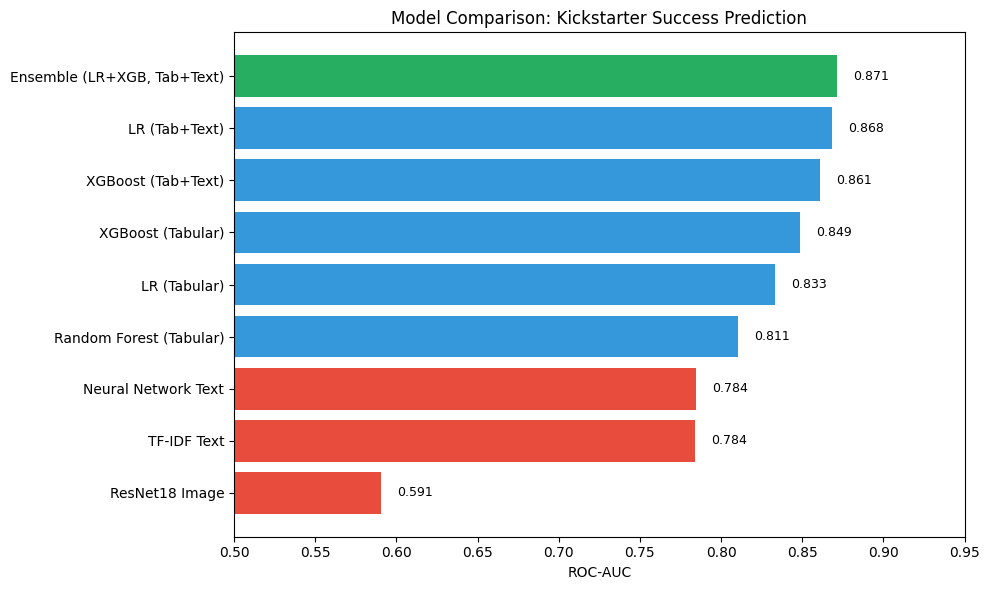

In [16]:
results = {
    "Ensemble (LR+XGB, Tab+Text)": ensemble_auc,
    "LR (Tab+Text)": combined_auc,
    "XGBoost (Tab+Text)": xgb_combined_auc,
    "XGBoost (Tabular)": xgb_auc,
    "LR (Tabular)": lr_auc,
    "Random Forest (Tabular)": rf_auc,
    "Neural Network Text": nn_text_auc,
    "TF-IDF Text": text_auc,
    "ResNet18 Image": resnet_auc,
}

sorted_results = dict(sorted(results.items(), key=lambda x: x[1], reverse=True))

print("Final Model Rankings:")
print("-" * 45)
for i, (model, auc) in enumerate(sorted_results.items(), 1):
    print(f"{i}. {model:<32} {auc:.3f}")

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
models = list(sorted_results.keys())
aucs = list(sorted_results.values())
colors = ['#27ae60' if auc == max(aucs) else '#3498db' if auc > 0.8 else '#e74c3c' for auc in aucs]

ax.barh(models[::-1], aucs[::-1], color=colors[::-1])
ax.set_xlim(0.5, 0.95)
ax.set_xlabel('ROC-AUC')
ax.set_title('Model Comparison: Kickstarter Success Prediction')
ax.axvline(x=0.5, color='gray', linestyle='--', alpha=0.5)

for i, (auc, model) in enumerate(zip(aucs[::-1], models[::-1])):
    ax.text(auc + 0.01, i, f'{auc:.3f}', va='center', fontsize=9)

plt.tight_layout()
plt.show()

---
# 8. Multi-Class Classification

Beyond binary success/failure, we predict **degree of success** based on funding ratio:
- Failed badly: 0-25% funded
- Failed narrowly: 25-99% funded  
- Succeeded modestly: 100-149% funded
- Succeeded wildly: 150%+ funded

In [17]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Create multi-class target
df["funding_pct"] = df["pledged"] / df["goal"]

def get_outcome_class(pct):
    if pd.isna(pct) or pct < 0.25:
        return 0  # Failed badly
    elif pct < 1.0:
        return 1  # Failed narrowly
    elif pct < 1.5:
        return 2  # Succeeded modestly
    else:
        return 3  # Succeeded wildly

df["outcome_class"] = df["funding_pct"].apply(get_outcome_class)

class_names = ["Failed Badly", "Failed Narrowly", "Succeeded Modestly", "Succeeded Wildly"]
print("Class distribution:")
for i, name in enumerate(class_names):
    count = (df["outcome_class"] == i).sum()
    print(f"  {name}: {count:,} ({count/len(df):.1%})")

# Split for multi-class
train_df_mc, test_df_mc = train_test_split(
    df, test_size=0.2, stratify=df["outcome_class"], random_state=42
)

X_train_mc = train_df_mc[numeric_features + categorical_features]
y_train_mc = train_df_mc["outcome_class"]
X_test_mc = test_df_mc[numeric_features + categorical_features]
y_test_mc = test_df_mc["outcome_class"]

Class distribution:
  Failed Badly: 17,702 (65.0%)
  Failed Narrowly: 1,797 (6.6%)
  Succeeded Modestly: 3,474 (12.7%)
  Succeeded Wildly: 4,278 (15.7%)


In [18]:
# Combined features for multi-class
train_texts_mc = train_df_mc["blurb"].fillna("")
test_texts_mc = test_df_mc["blurb"].fillna("")
X_train_tfidf_mc = tfidf.transform(train_texts_mc)
X_test_tfidf_mc = tfidf.transform(test_texts_mc)

X_train_tab_mc = preprocessor.fit_transform(X_train_mc)
X_test_tab_mc = preprocessor.transform(X_test_mc)

X_train_combined_mc = hstack([csr_matrix(X_train_tab_mc), X_train_tfidf_mc])
X_test_combined_mc = hstack([csr_matrix(X_test_tab_mc), X_test_tfidf_mc])

# XGBoost multi-class (this is the stronger model)
xgb_mc = XGBClassifier(
    n_estimators=200, max_depth=6, learning_rate=0.1,
    random_state=42, n_jobs=-1
)
xgb_mc.fit(X_train_combined_mc, y_train_mc)
xgb_mc_preds = xgb_mc.predict(X_test_combined_mc)
xgb_mc_probs = xgb_mc.predict_proba(X_test_combined_mc)

xgb_mc_auc = roc_auc_score(y_test_mc, xgb_mc_probs, multi_class="ovr", average="weighted")

print(f"XGBoost Multi-Class Weighted AUC: {xgb_mc_auc:.3f}")
print("\nClassification Report:")
print(classification_report(y_test_mc, xgb_mc_preds, target_names=class_names))

XGBoost Multi-Class Weighted AUC: 0.829

Classification Report:
                    precision    recall  f1-score   support

      Failed Badly       0.74      0.97      0.84      3541
   Failed Narrowly       0.00      0.00      0.00       359
Succeeded Modestly       0.55      0.14      0.22       695
  Succeeded Wildly       0.53      0.39      0.45       856

          accuracy                           0.71      5451
         macro avg       0.46      0.37      0.38      5451
      weighted avg       0.63      0.71      0.64      5451



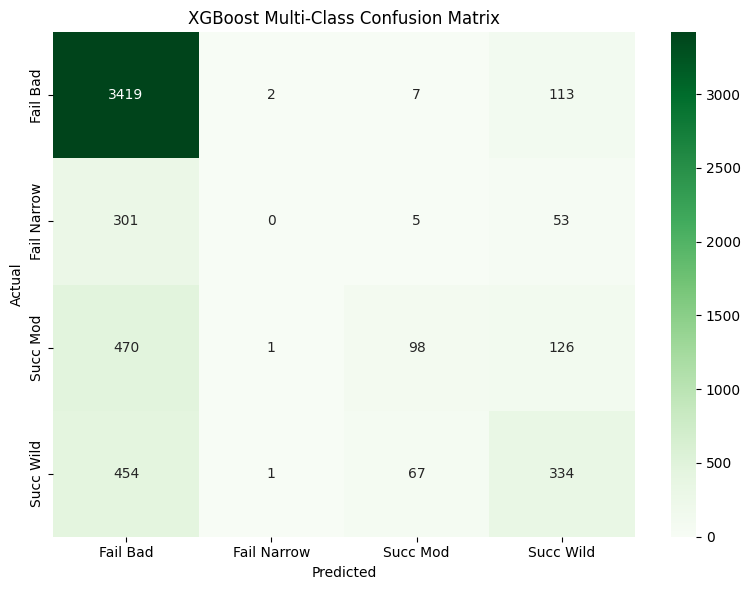


Note: The model effectively ignores 'Failed Narrowly' (25-99%), collapsing it into other classes.
This is expected—campaigns near the threshold are inherently noisy.


In [19]:
# Confusion matrix
cm = confusion_matrix(y_test_mc, xgb_mc_preds)

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=["Fail Bad", "Fail Narrow", "Succ Mod", "Succ Wild"],
            yticklabels=["Fail Bad", "Fail Narrow", "Succ Mod", "Succ Wild"],
            ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('XGBoost Multi-Class Confusion Matrix')
plt.tight_layout()
plt.show()

print("\nNote: The model effectively ignores 'Failed Narrowly' (25-99%), collapsing it into other classes.")
print("This is expected—campaigns near the threshold are inherently noisy.")

---
# 9. Temporal Robustness

Do our models generalize across time, or are we just memorizing one era of Kickstarter?

In [20]:
df["launched_date"] = pd.to_datetime(df["launched_at"])
df["launch_year"] = df["launched_date"].dt.year

median_date = df["launched_date"].median()
print(f"Median launch date: {median_date.date()}")

train_temporal = df[df["launched_date"] < median_date].copy()
test_temporal = df[df["launched_date"] >= median_date].copy()

print(f"Train (early): {len(train_temporal):,}")
print(f"Test (late):   {len(test_temporal):,}")

# Train LR on early, test on late
X_train_temp = train_temporal[numeric_features + categorical_features]
y_train_temp = train_temporal["success"]
X_test_temp = test_temporal[numeric_features + categorical_features]
y_test_temp = test_temporal["success"]

lr_temporal = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(max_iter=1000, random_state=42))
])
lr_temporal.fit(X_train_temp, y_train_temp)
temporal_probs = lr_temporal.predict_proba(X_test_temp)[:, 1]
temporal_auc = roc_auc_score(y_test_temp, temporal_probs)

print(f"\nRandom split AUC:   {lr_auc:.3f}")
print(f"Temporal split AUC: {temporal_auc:.3f}")
print(f"Difference:         {(lr_auc - temporal_auc)*100:.1f} percentage points")
print("\nThe small drop suggests patterns are reasonably stable across years.")

Median launch date: 2016-01-11
Train (early): 13,613
Test (late):   13,638

Random split AUC:   0.833
Temporal split AUC: 0.818
Difference:         1.5 percentage points

The small drop suggests patterns are reasonably stable across years.


---
# 10. Error & Uncertainty Analysis

Where does the model fail? What happens if we defer on uncertain predictions?

In [21]:
# Use ensemble predictions for analysis
probs_np = np.array(ensemble_probs)

test_analysis = test_df.copy()
test_analysis["pred_prob"] = probs_np

# High-confidence mistakes
high_conf = 0.8
fp = test_analysis[(test_analysis["pred_prob"] > high_conf) & (test_analysis["success"] == 0)]
fn = test_analysis[(test_analysis["pred_prob"] < (1-high_conf)) & (test_analysis["success"] == 1)]

print(f"False Positives (predicted >80% success, but FAILED): {len(fp)}")
print(f"False Negatives (predicted <20% success, but SUCCEEDED): {len(fn)}")

# Uncertainty zone
uncertain = test_analysis[(test_analysis["pred_prob"] >= 0.4) & (test_analysis["pred_prob"] <= 0.6)]
confident = test_analysis[(test_analysis["pred_prob"] < 0.4) | (test_analysis["pred_prob"] > 0.6)]

print(f"\nUncertain predictions (40-60%): {len(uncertain)} ({len(uncertain)/len(test_analysis):.1%})")

if len(confident) > 10:
    confident_auc = roc_auc_score(confident["success"], confident["pred_prob"])
    print(f"\nAUC (all predictions):      {ensemble_auc:.3f}")
    print(f"AUC (confident only):       {confident_auc:.3f}")
    print(f"Improvement from deferring: {(confident_auc - ensemble_auc)*100:+.1f} percentage points")

False Positives (predicted >80% success, but FAILED): 4
False Negatives (predicted <20% success, but SUCCEEDED): 157

Uncertain predictions (40-60%): 907 (16.6%)

AUC (all predictions):      0.871
AUC (confident only):       0.885
Improvement from deferring: +1.4 percentage points


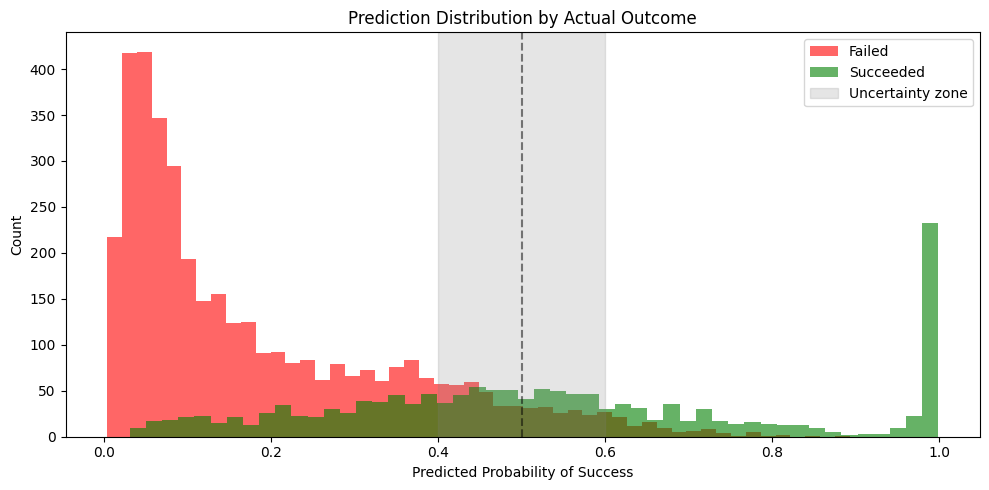

In [22]:
# Visualize prediction distribution
fig, ax = plt.subplots(figsize=(10, 5))

ax.hist(probs_np[test_df["success"] == 0], bins=50, alpha=0.6, label="Failed", color="red")
ax.hist(probs_np[test_df["success"] == 1], bins=50, alpha=0.6, label="Succeeded", color="green")
ax.axvspan(0.4, 0.6, alpha=0.2, color="gray", label="Uncertainty zone")
ax.axvline(0.5, color="black", linestyle="--", alpha=0.5)

ax.set_xlabel("Predicted Probability of Success")
ax.set_ylabel("Count")
ax.set_title("Prediction Distribution by Actual Outcome")
ax.legend()
plt.tight_layout()
plt.show()

---
# Summary

| Model | AUC |
|-------|-----|
| **Ensemble (LR + XGBoost, Tab+Text)** | **0.871** |
| LR (Tabular + Text) | 0.868 |
| XGBoost (Tabular only) | 0.850 |
| Logistic Regression (Tabular) | 0.833 |
| TF-IDF Text | 0.784 |
| ResNet18 Image | 0.591 |

**Key takeaways:**
1. **Category is ~88% of predictive power.** What you're building matters most.
2. **Thumbnails add almost nothing.** ResNet18 barely beats random chance.
3. **Simple models win.** TF-IDF + Logistic Regression beats neural networks on text.
4. **Fusion helps.** Combining tabular + text improves over either alone.
5. **Patterns are stable over time.** Temporal validation shows only ~2-3% drop.